In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, convert_weekly_panel_to_biweekly_panel, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_1_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/{analysis}/figures"
OUTPUT_TABLES = f"../../output/{analysis}/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [2]:
pre_pandemic_months = ['2019-04'
                       '2019-05'
                       '2019-06',
                       '2019-07',
                       '2019-08',
                       '2019-09',
                       '2019-10',
                       '2019-11',
                       '2019-12',
                       '2020-01',
                       '2020-02',
                       '2020-03']

df = df.loc[df['latest_docket_month'].isin(pre_pandemic_months), :]

In [3]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)
# df = convert_weekly_panel_to_biweekly_panel(df, treatment_date_variable, analysis)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [4]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                                                  
                                                 \emph{Independent Variable}                                      
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_1_crimes_500m        1.985861e-46   
                                                 pre_treatment_change_in_group_1_crimes_500m      9.559584e-155   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                1.170254e-03   
                                                 job_density_2013                                  6.373231e-71   
                                                 med_hhinc2016                                     6.201796e-11   
                                                 poor_share2010                                    3.067661e-03   
                                                 popdensity2010                                    1.306106e-02   
Panel C: Case Initiation                         for_cause                                         1.039969e-01   
                                                 no_cause                                          3.772775e-01   
                                                 non_payment                                       3.113763e-01   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                          2.924599e-01   
                                                 hasAttyP                                          3.282365e-01   
                                                 isEntityD                                         5.167266e-01   
                                                 isEntityP                                         7.294187e-01   

                                                                                                        
                                                                                                        
                                                 \emph{Independent Variable}                            
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_1_crimes_500m   0.103598  
                                                 pre_treatment_change_in_group_1_crimes_500m  0.920209  
Panel B: Census Tract Characteristics            frac_coll_plus2010                           0.026586  
                                                 job_density_2013                             0.285288  
                                                 med_hhinc2016                                0.006887  
                                                 poor_share2010                               0.007088  
                                                 popdensity2010                               0.568300  
Panel C: Case Initiation                         for_cause                                    0.000297  
                                                 no_cause                                     0.160724  
                                                 non_payment                                  0.035557  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                     0.000018  
                                                 hasAttyP                                     0.057909  
                                                 isEntityD                                    0.129970  
                                                 isEntityP                                    0.001203

In [5]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                              Cases Won by Plaintiff   
Panel A Total Group 1 Incidents, 2017                       2.976483   
        $\Delta$ Group 1 Incidents, 2017-2019              12.715746   
Panel B Bachelor's degree, 2010                             0.324037   
        Job density, 2013                               17879.131663   
        Median household income, 2016                   47493.957055   
        Poverty rate, 2010                                  0.284488   
        Population density, 2010                        23692.018106   

                                              Difference in Cases Won by Defendant  \
                                                                        Unweighted   
Panel A Total Group 1 Incidents, 2017                                     0.258741   
        $\Delta$ Group 1 Incidents, 2017-2019                             0.067359   
Panel B Bachelor's degree, 2010                                           0.024748   
        Job density, 2013                                              2380.874938   
        Median household income, 2016                                  3485.700604   
        Poverty rate, 2010                                               -0.020869   
        Population density, 2010                                        403.429752   

                                                                               
                                               \emph{p}    Weighted  \emph{p}  
Panel A Total Group 1 Incidents, 2017          0.103598    0.004291  0.975358  
        $\Delta$ Group 1 Incidents, 2017-2019  0.920209   -0.180394  0.787921  
Panel B Bachelor's degree, 2010                0.026586   -0.000188  0.981628  
        Job density, 2013                      0.285288  184.044430  0.931184  
        Median household income, 2016          0.006887  -54.604376  0.937510  
        Poverty rate, 2010                     0.007088   -0.008320  0.217288  
        Population density, 2010               0.568300 -282.900535  0.676253

In [6]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [7]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, base_period='universal')
result = att_gt.fit(formula=analysis, control_group='not_yet_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 920/920 [00:33<00:00, 27.79it/s]


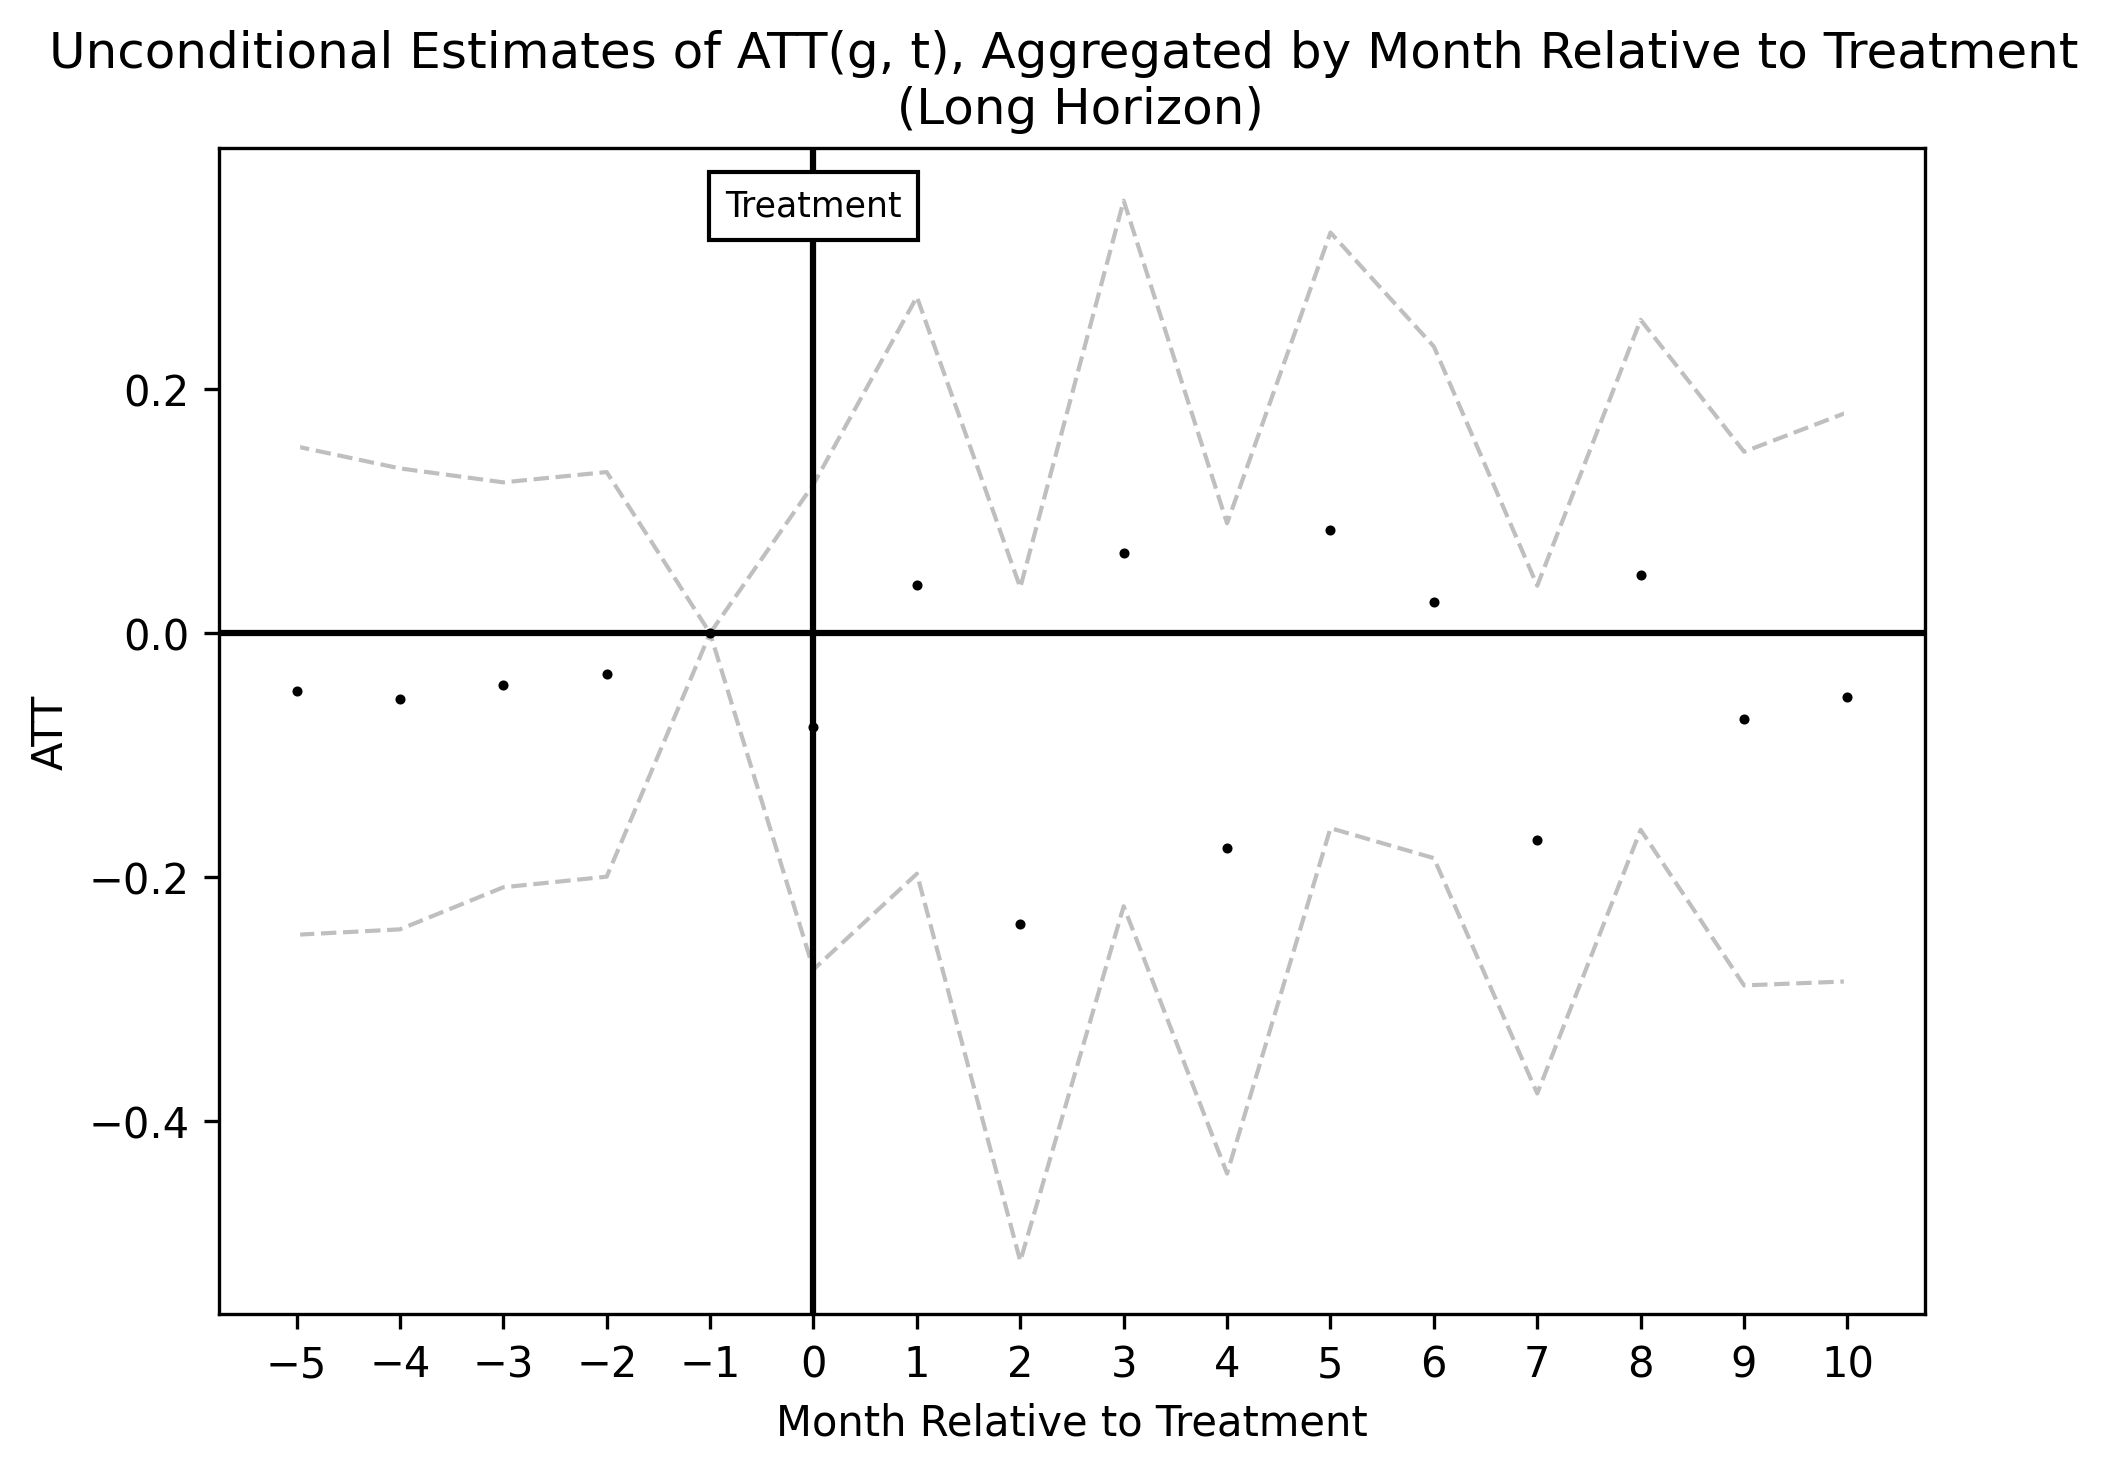

In [8]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-5, end_period=10,
                                 title="Unconditional Estimates of ATT(g, t), Aggregated by Month Relative to Treatment \n (Long Horizon)",
                                 treatment_month_variable=treatment_date_variable, df=df)

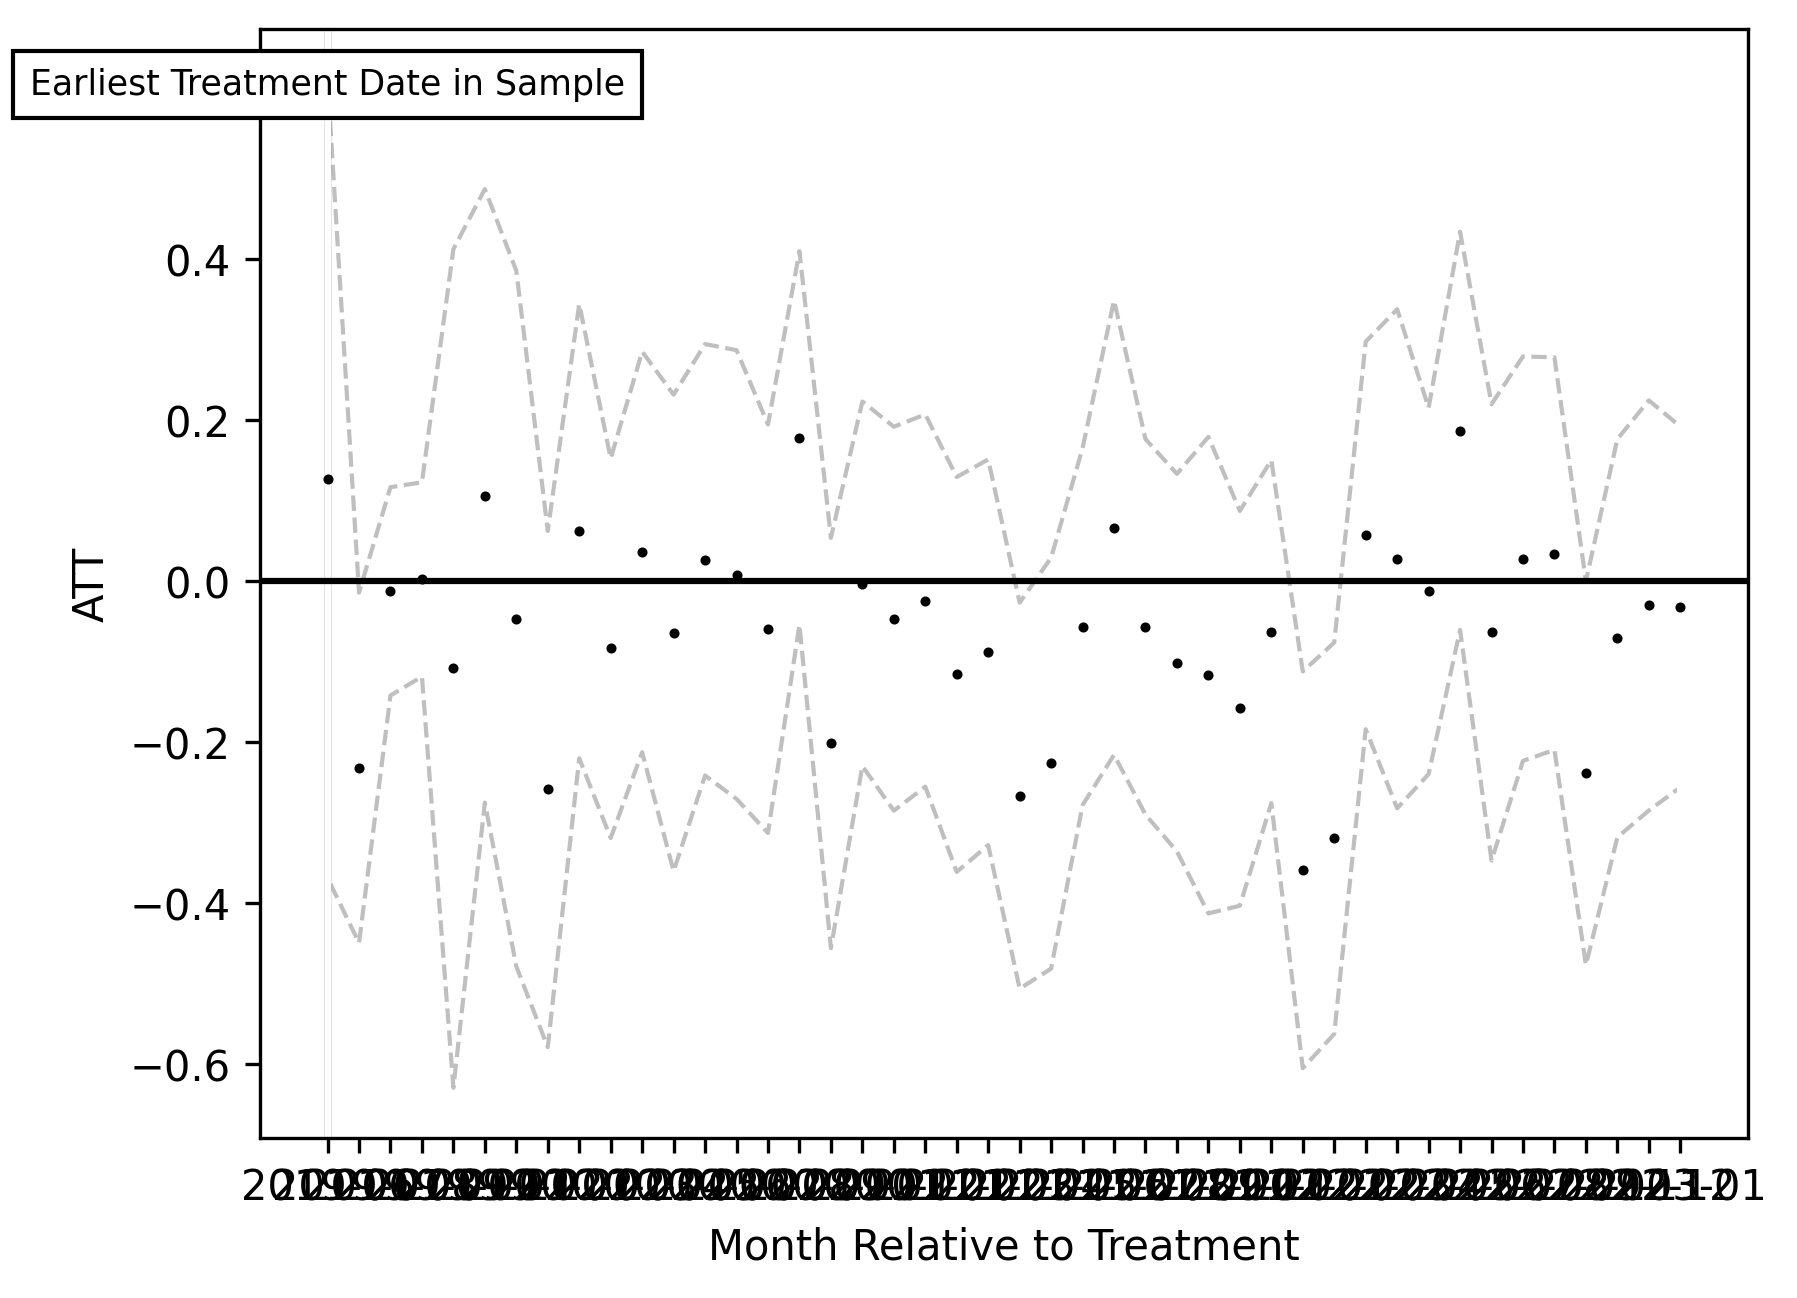

In [9]:
# Plot unconditional ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_unconditional_time.png",
                           title="")

In [10]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='not_yet_treated', n_jobs=1, progress_bar=True)

Computing ATTgt [workers=1]   100%|████████████████████| 920/920 [00:17<00:00, 51.17it/s]


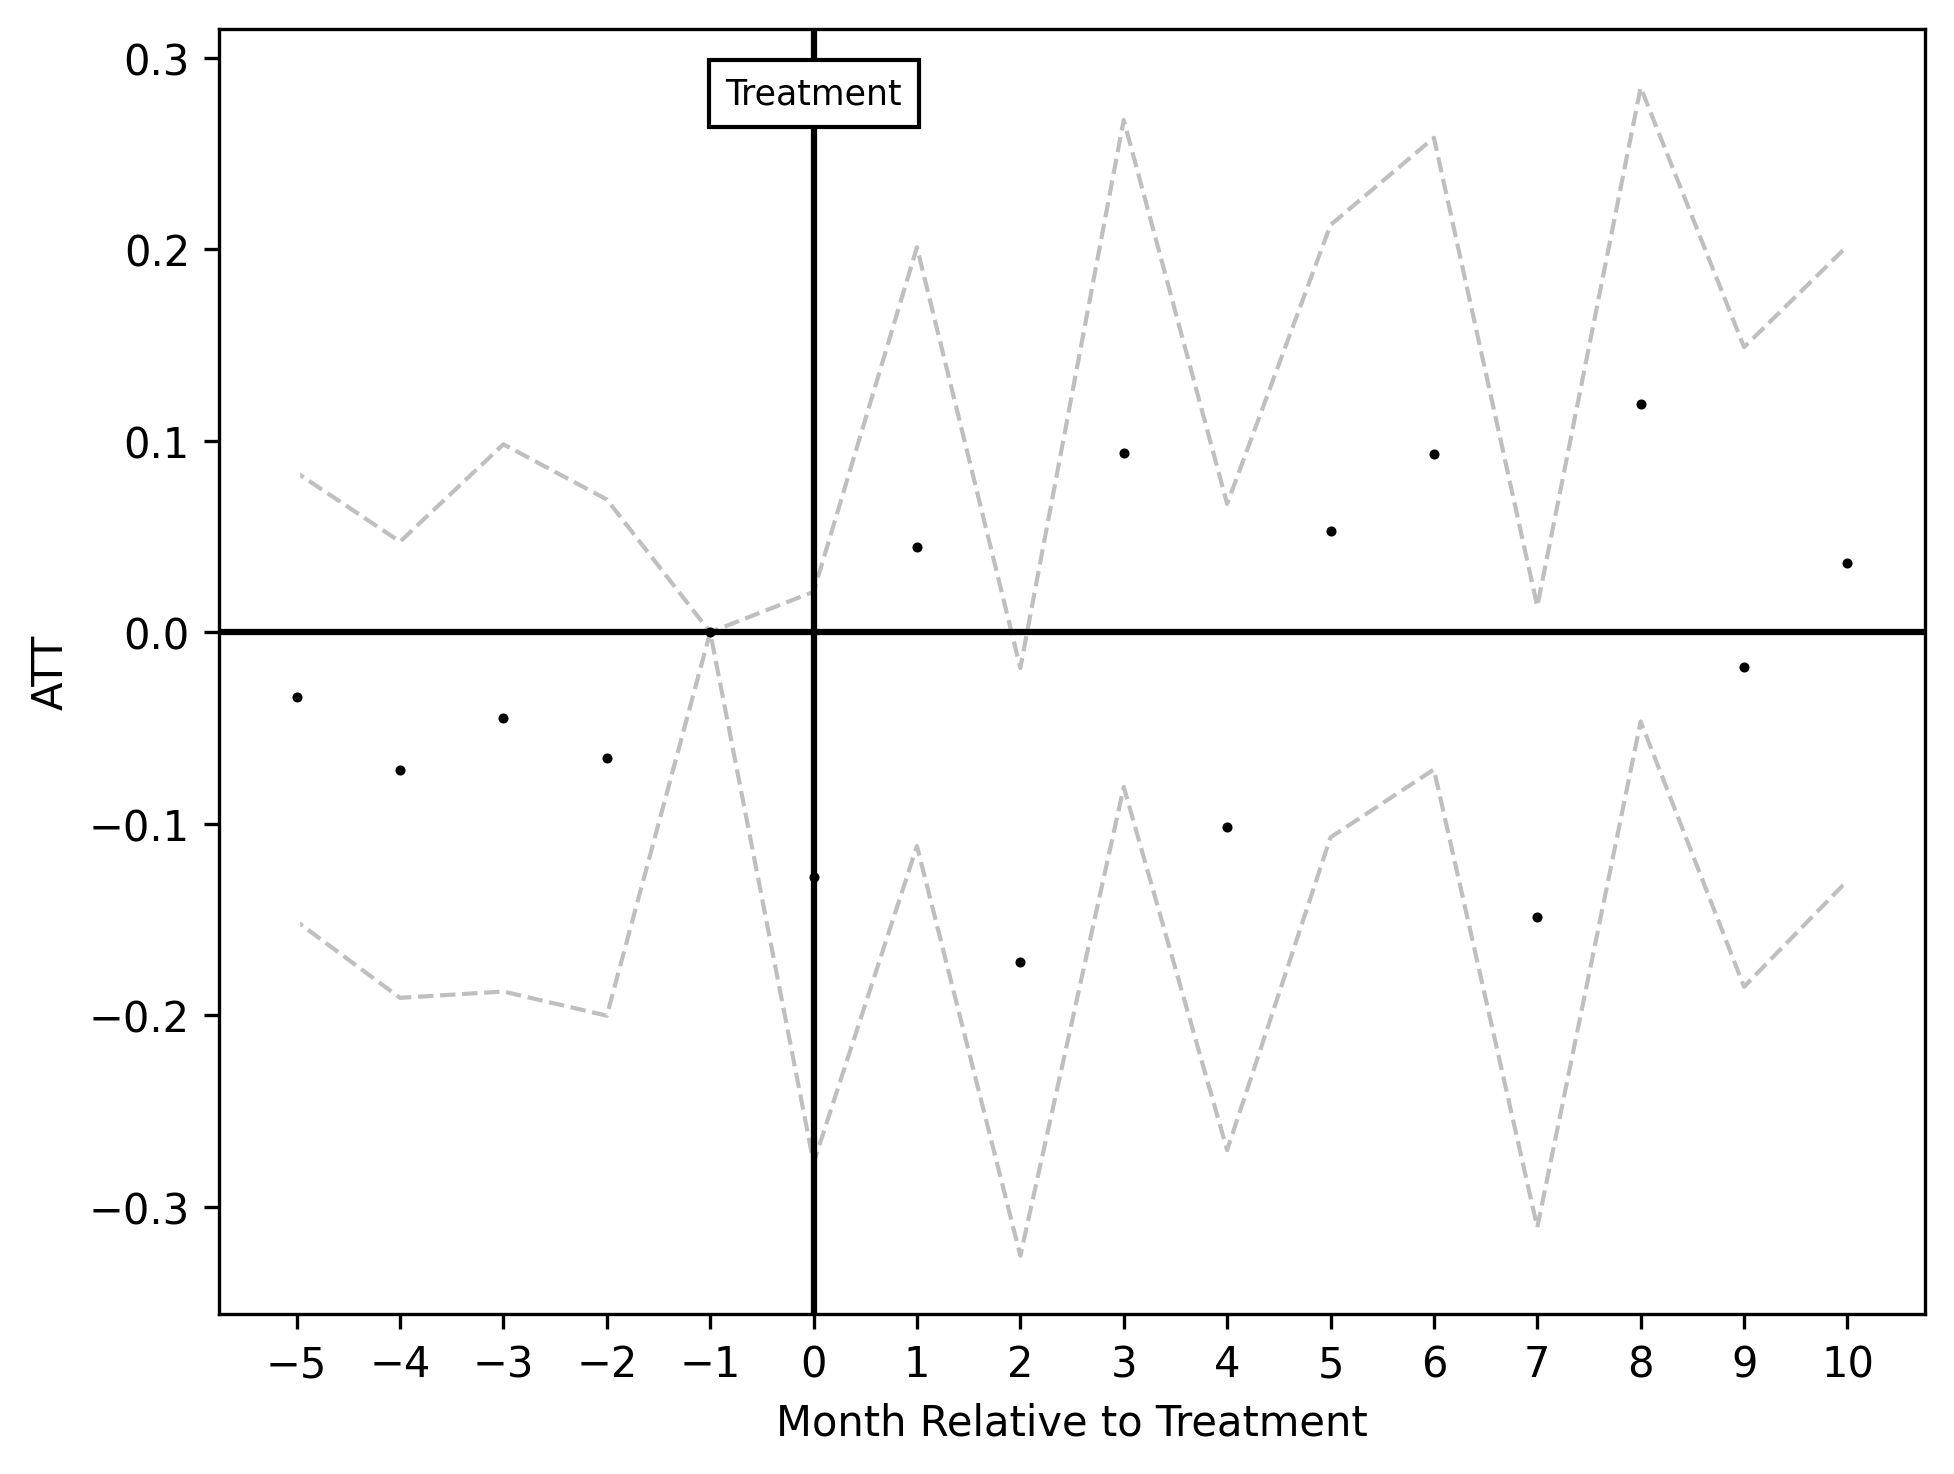

In [11]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-5,
                                 end_period=10,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

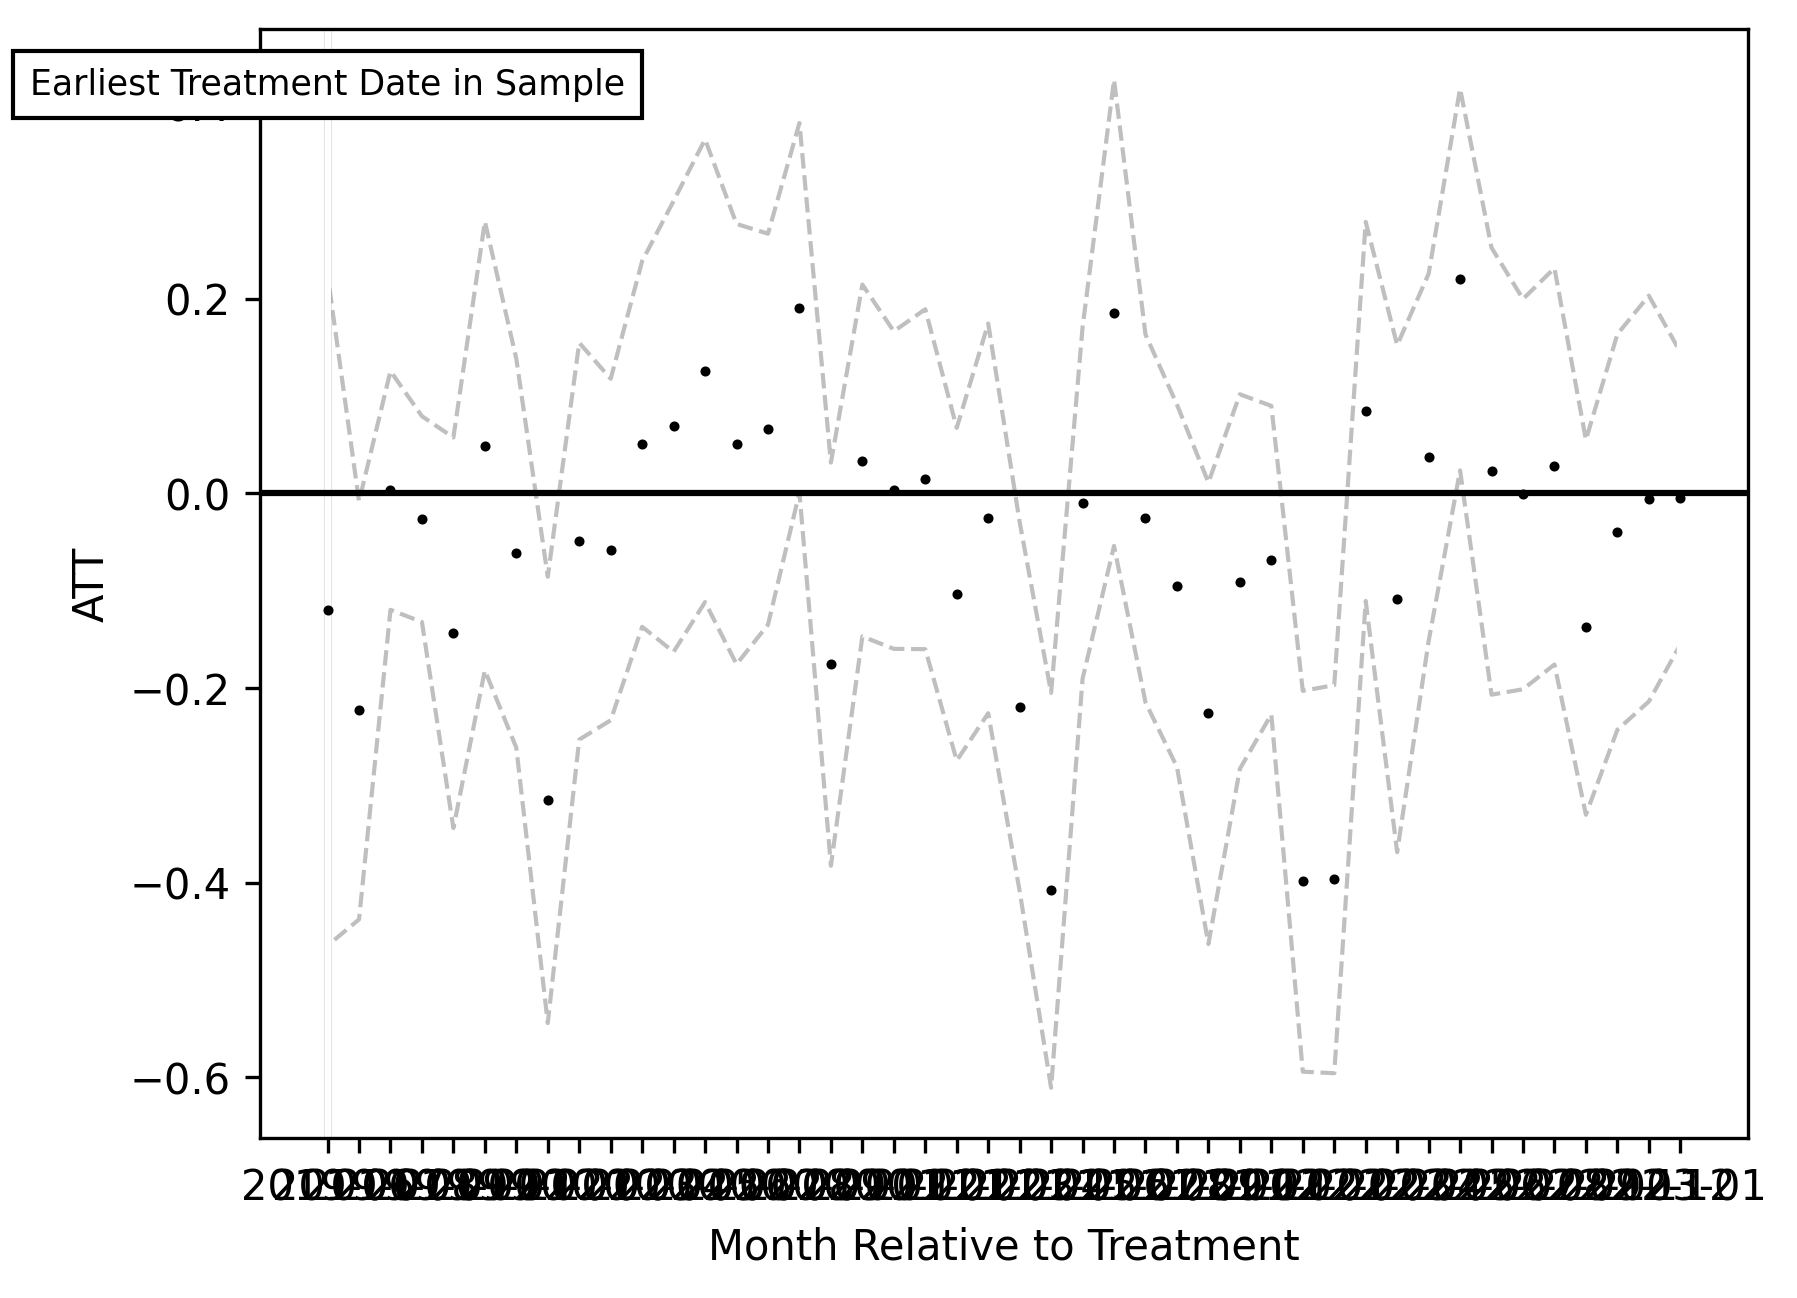

In [12]:
# Plot D.R. ATT(t)s.
aggregate_by_time_and_plot(att_gt, int_to_month_dictionary, OUTPUT_FIGURES, "att_gt_dr_time.png",
                           title="")